<a href="https://colab.research.google.com/github/OkanBagriacik/Energy-Project/blob/main/Machine_Learning_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve, classification_report, roc_auc_score, auc, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
import warnings
from google.colab import drive
import xgboost as xg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib

In [ ]:
data =pd.read_csv("EnergyData_2.csv")
data = data[["SolarPV_Consumption","Panel Count", "Weather", "BelowUnderAVG"]]
data

,SolarPV_Consumption,Panel Count,Weather,BelowUnderAVG
0,4657,50,0,0
1,6682,100,1,1
2,7126,100,1,1
3,7097,100,1,1
4,7119,100,1,1
...,...,...,...,...
364,6704,100,1,1
365,4276,100,0,0
366,4678,100,1,1
367,3330,50,0,0


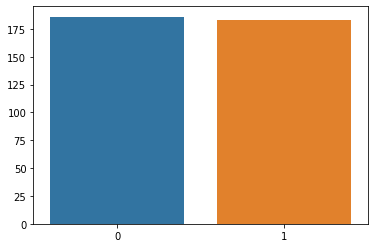

In [ ]:
target = data["BelowUnderAVG"].value_counts()
sns.barplot(x = target.keys(),
            y = target.values)

In [ ]:
def trainTestSplitData(data, trainLen):
##
## Splits data for train (Model Training) and test (Model Evaluating)
## @params = {data: data for split, testLen: train data ratio}
## @returns = {x_train, x_test, y_train, y_test, x_val, y_val : base and target data for model}
##
  X = data.drop(["BelowUnderAVG"], axis = 1)
  y = data["BelowUnderAVG"]
  trainLen = int(data.shape[0] * trainLen)
  
  x_train, x_test, y_train, y_test = X[:trainLen], X[trainLen:], y[:trainLen], y[trainLen:]
  
  del X
  del y
  return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = trainTestSplitData(data, 0.5)

In [ ]:
print(f"Train Data Shape: {x_train.shape} Train Target Shape: {y_train.shape}")

print(f"Test Data Shape: {x_test.shape} Test Target Shape: {y_test.shape}")

Train Data Shape: (184, 3) Train Target Shape: (184,)
Test Data Shape: (185, 3) Test Target Shape: (185,)


In [ ]:
def gridSearchCrossValidation(tunedParams,
                              scores,
                              x_train,
                              x_test,
                              y_train,
                              y_test,
                              modelType = "KNN"
                              ):
  ###
  ### Cross Validation for test model metric and hyper-parameter tuning
  ### @params = {tunedParams: hyper-parameters for dataset, scores: accuracy metrics, x_train/y_train/x_val/y_val: datasets, modelType: algorithm type (KNN, RF, XGB)}
  ###
  for score in scores:
    print(f"Hyper-Parameter Tuning for {score}")
    if modelType == "KNN":
      model = GridSearchCV(KNeighborsClassifier(),
                           tunedParams,
                           scoring = f"{score}_macro")
    elif modelType == "RF":
      model = GridSearchCV((RandomForestClassifier()),
                           tunedParams,
                           scoring = f"{score}_macro")
    elif modelType == "XGB":
      model = GridSearchCV(xg.XGBClassifier(),
                           tunedParams,
                           scoring = f"{score}_macro")
    
    model.fit(x_train, y_train)
    print("Best parameters set found on development set:")
    print(model.best_params_)
    print("Grid scores on development set:")
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("Detailed classification report:")
    y_true, y_pred = y_test, model.predict(x_test)
    print(classification_report(y_true, y_pred))

In [ ]:
tunedParams = [{"n_neighbors": [3,5,7],
                "weights": ["uniform", "distance"],
                "p": [1,2]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_test,
                          y_train,
                          y_test,
                          modelType = "KNN")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Grid scores on development set:
0.860 (+/-0.095) for {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
0.867 (+/-0.138) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
0.857 (+/-0.094) for {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
0.862 (+/-0.132) for {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.866 (+/-0.121) for {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
0.864 (+/-0.155) for {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
0.864 (+/-0.125) for {'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.861 (+/-0.157) for {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
0.859 (+/-0.121) for {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.875 (+/-0.150) for {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
0.855 (+/-0.128) for {'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
0.875 (+/-0.150) for {'n_neighbors': 7, 'p': 2, 'weights': '

In [ ]:
tunedParams = [{"n_estimators": [10, 50, 100],
                "criterion": ["gini", "entropy"],
                "max_features": ["auto", "sqrt", "log2"]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_test,
                          y_train,
                          y_test,
                          modelType = "RF")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 50}
Grid scores on development set:
0.902 (+/-0.146) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 10}
0.976 (+/-0.052) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 50}
0.936 (+/-0.143) for {'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 100}
0.976 (+/-0.052) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 10}
0.976 (+/-0.052) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 50}
0.976 (+/-0.052) for {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}
0.976 (+/-0.052) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 10}
0.904 (+/-0.140) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 50}
0.942 (+/-0.118) for {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 100}
0.976 (+/-0.052) for {'criterion'

In [ ]:
tunedParams = [{"min_child_weight": [5, 10],
                "colsample_bytree": [0.6, 0.8]}]
scores = ["precision", "recall"]
gridSearchCrossValidation(tunedParams,
                          scores,
                          x_train,
                          x_test,
                          y_train,
                          y_test,
                          modelType = "XGB")

Hyper-Parameter Tuning for precision
Best parameters set found on development set:
{'colsample_bytree': 0.8, 'min_child_weight': 10}
Grid scores on development set:
0.917 (+/-0.166) for {'colsample_bytree': 0.6, 'min_child_weight': 5}
0.917 (+/-0.166) for {'colsample_bytree': 0.6, 'min_child_weight': 10}
0.950 (+/-0.152) for {'colsample_bytree': 0.8, 'min_child_weight': 5}
0.990 (+/-0.024) for {'colsample_bytree': 0.8, 'min_child_weight': 10}
Detailed classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00        90

    accuracy                           1.00       185
   macro avg       1.00      1.00      1.00       185
weighted avg       1.00      1.00      1.00       185

Hyper-Parameter Tuning for recall
Best parameters set found on development set:
{'colsample_bytree': 0.8, 'min_child_weight': 10}
Grid scores on development set:
0.875 (+/-0.269) for {'colsample

In [ ]:
model = RandomForestClassifier(criterion = 'entropy', 
                               max_features = 'sqrt', 
                               n_estimators = 100)

In [ ]:
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

<Figure size 1440x1440 with 0 Axes>

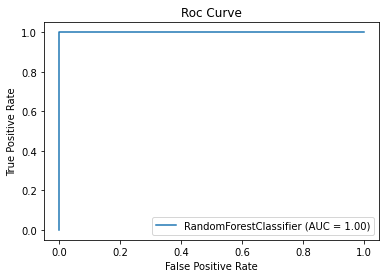

In [ ]:
plt.figure(figsize= (20,20))
plot_roc_curve(model, x_test, y_test)
plt.title("Roc Curve")
plt.show()

In [ ]:
predicts = model.predict(x_test)
predictionData = {"Index": range(x_test.shape[0]),
                      "Actual": y_test,
                      "Prediction": predicts}
predictionData = pd.DataFrame(predictionData)
predictionData

,Index,Actual,Prediction
184,0,1,1
185,1,0,0
186,2,0,0
187,3,0,0
188,4,0,0
...,...,...,...
364,180,1,1
365,181,0,0
366,182,1,1
367,183,0,0
